In [1]:
import tensorflow as tf

# 사용 가능한 GPU 리스트 출력
gpus = tf.config.list_physical_devices('GPU')
print("사용 가능한 GPU:", gpus)

# GPU 사용 여부 확인
if gpus:
    print("GPU를 사용할 수 있습니다.")
else:
    print("GPU를 사용할 수 없습니다.")


사용 가능한 GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU를 사용할 수 있습니다.


# 모델 학습을 위한 데이터셋(dataset) 준비하기

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Matplotlib is building the font cache; this may take a moment.


In [3]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='plant_village',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    download=True,
    with_info=True, # 데이터셋 정보(ds_info) 함께 반환
    as_supervised=True, # (이미지, 레이블) 튜플 반환
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/54303 [00:00<?, ? examples/s]

Shuffling plant_village-train.tfrecord...:   0%|          | 0/54303 [00:00<?, ? examples/s]

Dataset plant_village downloaded and prepared to /aiffel/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


In [4]:
try:
    # 각 데이터셋의 크기(샘플 수) 계산
    num_train_images = tf.data.experimental.cardinality(raw_train).numpy()
    num_val_images = tf.data.experimental.cardinality(raw_validation).numpy()
    num_test_images = tf.data.experimental.cardinality(raw_test).numpy()

    # TensorFlow가 크기를 알 수 없는 경우 (-2 또는 -1 반환) 처리
    if num_train_images < 0 or num_val_images < 0 or num_test_images < 0:
        print("경고: 일부 데이터셋의 전체 크기를 자동으로 파악할 수 없습니다.")
        print("       .filter() 등의 변환이 적용되었거나 TFDS 메타데이터에 크기 정보가 없을 수 있습니다.")

    # 결과 출력 (크기를 알 수 있는 경우)
    if num_train_images >= 0 and num_val_images >= 0 and num_test_images >= 0:
        print(f"총 학습 이미지 개수: {num_train_images}")
        print(f"총 검증 이미지 개수: {num_val_images}")
        print(f"총 테스트 이미지 개수: {num_test_images}")
        print(f"전체 이미지 개수 (모든 스플릿 합계): {num_train_images + num_val_images + num_test_images}")

except NameError:
    print("오류: 'raw_train', 'raw_validation', 'raw_test' 변수를 찾을 수 없습니다.")
except Exception as e:
    print(f"이미지 개수 계산 중 오류 발생: {e}")

총 학습 이미지 개수: 43442
총 검증 이미지 개수: 5431
총 테스트 이미지 개수: 5430
전체 이미지 개수 (모든 스플릿 합계): 54303


# 데이터 시각화, 전처리

In [5]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [6]:
IMG_SIZE = 160 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1 # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


In [7]:
def count_labels(dataset, dataset_name, class_names):
    label_counter = Counter()
    for _, label in dataset:
        label_counter.update([label.numpy()]) # 레이블(텐서)을 numpy 값으로 변환하여 카운트
        
    counts = []         # 각 클래스별 개수를 저장할 리스트
    names_ordered = []  # 클래스 이름 순서대로 저장할 리스트
    num_classes = len(class_names)
    for i in range(num_classes):
        count = label_counter[i] # 해당 클래스 인덱스의 개수 가져오기 (없으면 0)
        counts.append(count)
        names_ordered.append(class_names[i]) # 클래스 인덱스 순서대로 이름 추가
    # 순서가 보장된 이름 리스트와 카운트 리스트 반환
    return names_ordered, counts

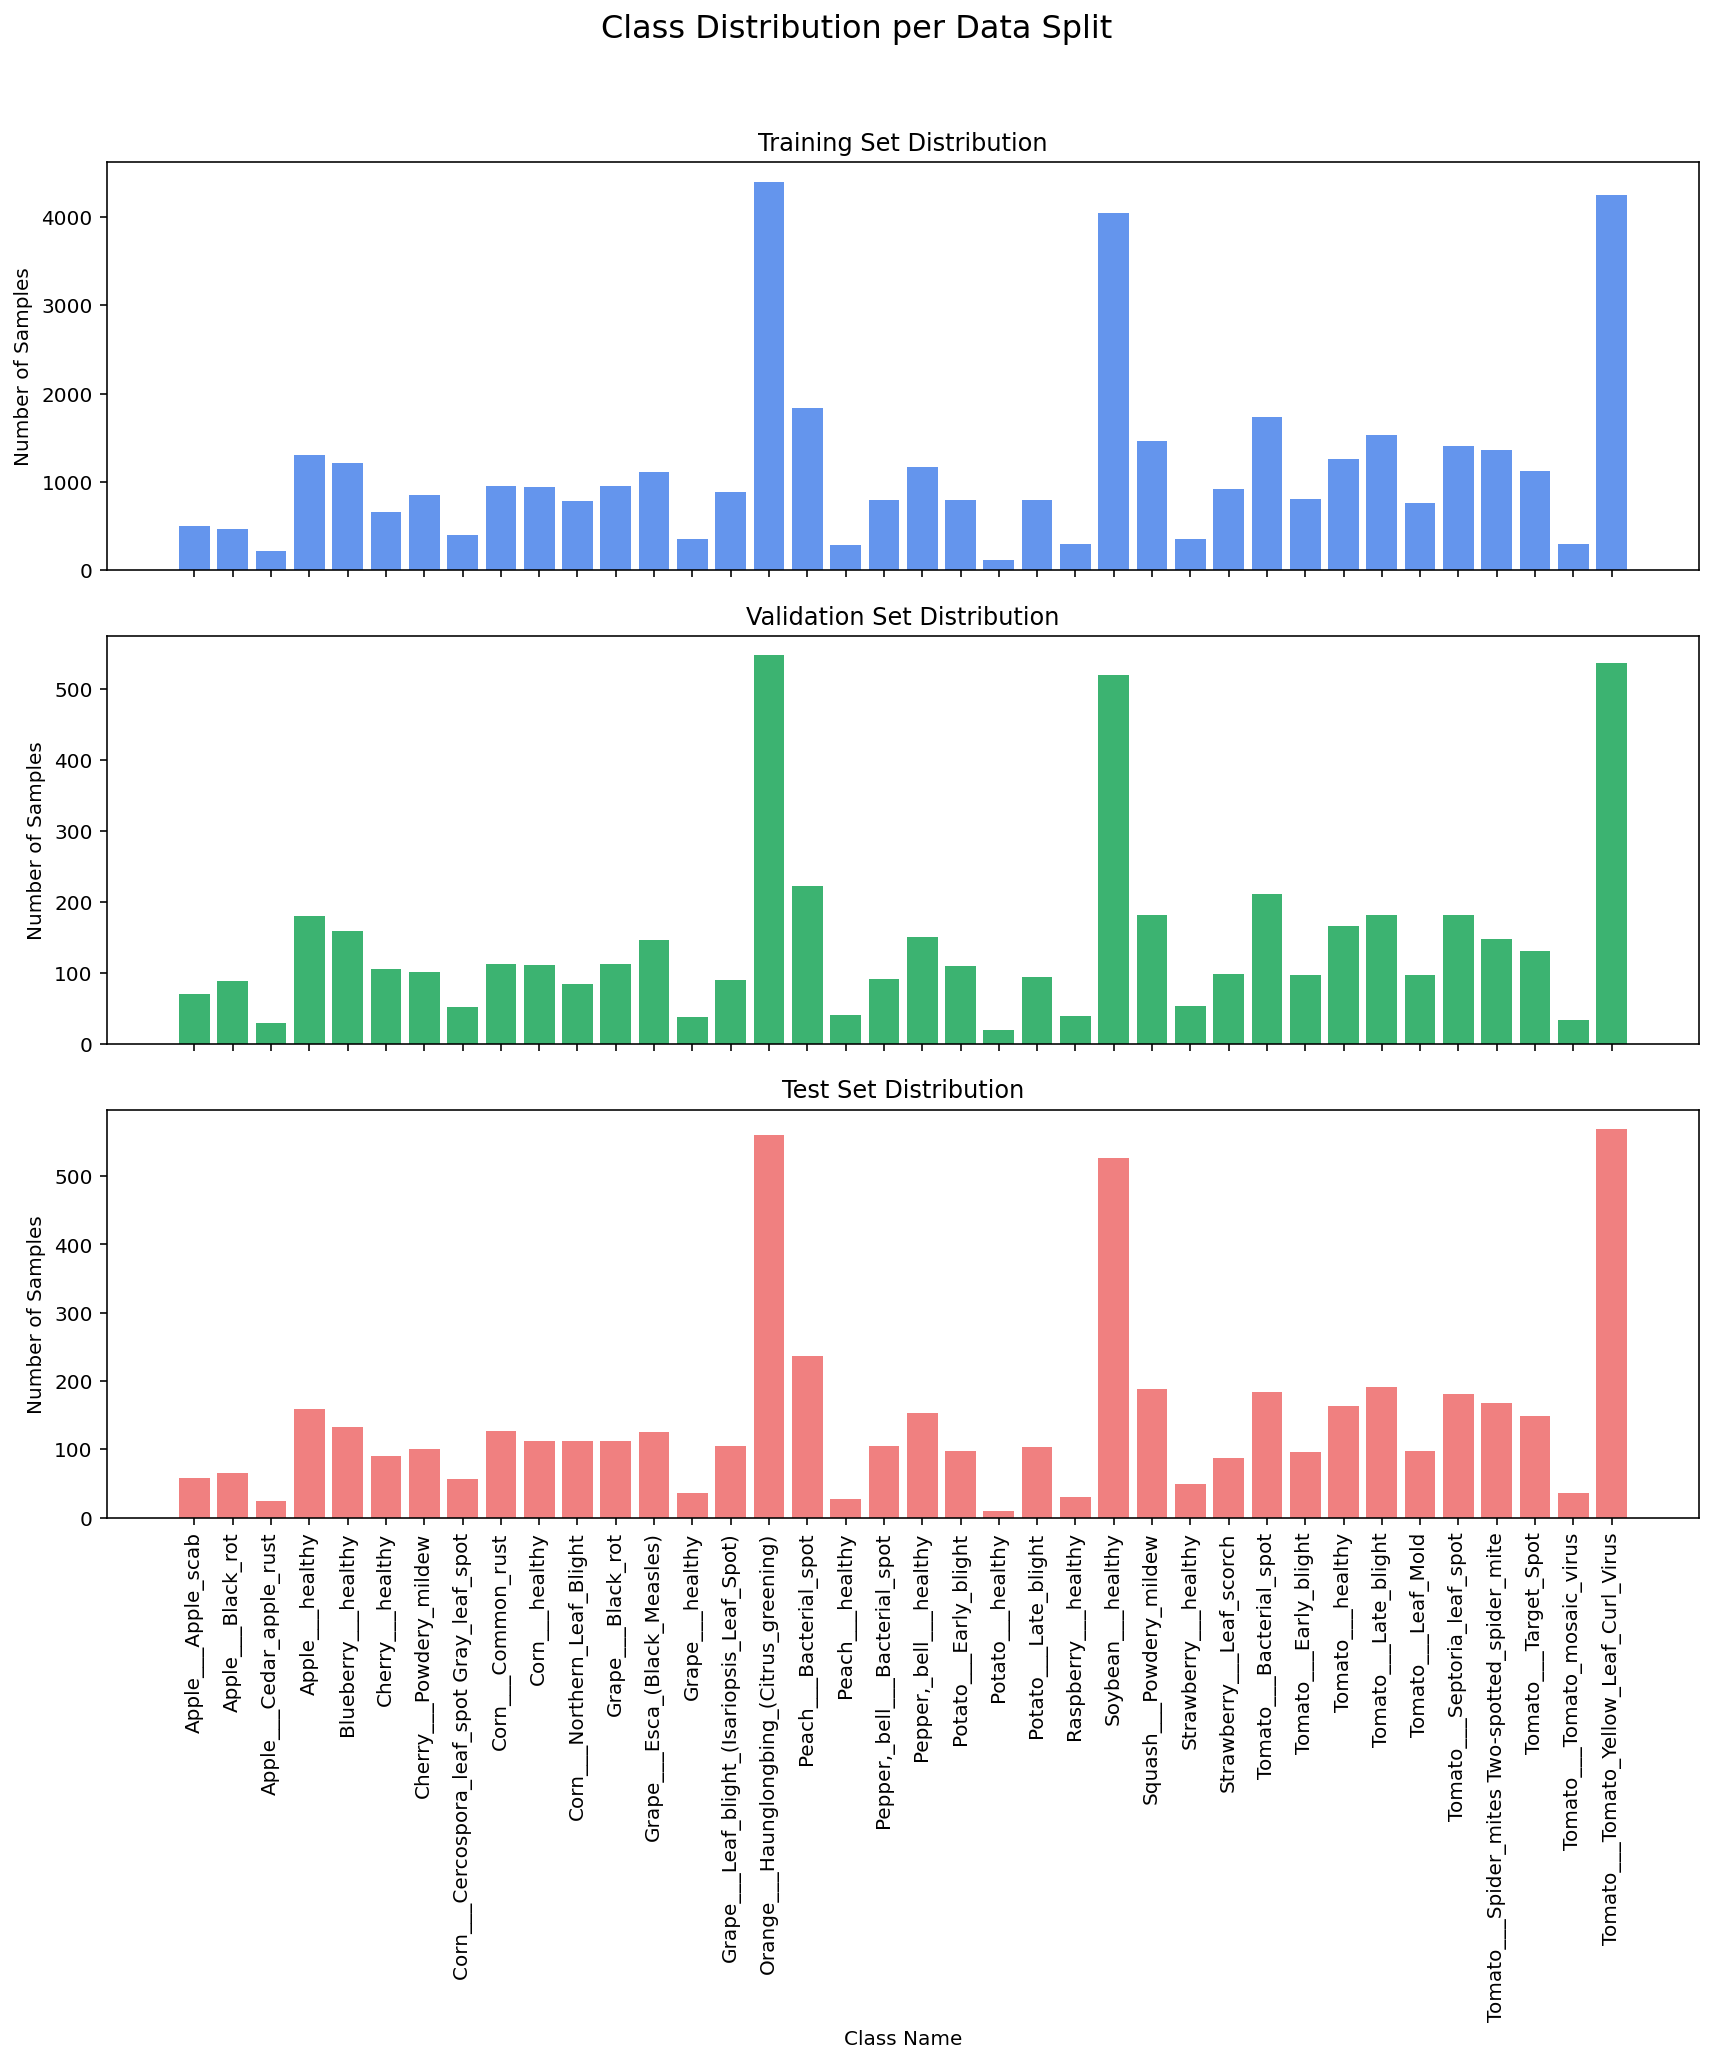

In [8]:
# 메타데이터에서 클래스 이름 가져오기
class_names = metadata.features['label'].names

# 각 스플릿별로 레이블 카운트 실행
train_names, train_counts = count_labels(raw_train, "학습 데이터 (raw_train)", class_names)
val_names, val_counts = count_labels(raw_validation, "검증 데이터 (raw_validation)", class_names)
test_names, test_counts = count_labels(raw_test, "테스트 데이터 (raw_test)", class_names)

# 3개의 서브플롯을 세로로 배치 (학습, 검증, 테스트)
fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True) 
fig.suptitle('Class Distribution per Data Split', fontsize=16)

# 1. 학습 데이터 분포 (Training Set)
axes[0].bar(train_names, train_counts, color='cornflowerblue')
axes[0].set_title('Training Set Distribution')
axes[0].set_ylabel('Number of Samples') 
axes[0].tick_params(axis='x', rotation=90)

# 2. 검증 데이터 분포 (Validation Set)
axes[1].bar(val_names, val_counts, color='mediumseagreen')
axes[1].set_title('Validation Set Distribution')
axes[1].set_ylabel('Number of Samples')
axes[1].tick_params(axis='x', rotation=90)

# 3. 테스트 데이터 분포 (Test Set)
axes[2].bar(test_names, test_counts, color='lightcoral')
axes[2].set_title('Test Set Distribution') 
axes[2].set_ylabel('Number of Samples')  
axes[2].set_xlabel('Class Name')
axes[2].tick_params(axis='x', rotation=90)

# 레이아웃 자동 조정 및 그래프 출력
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

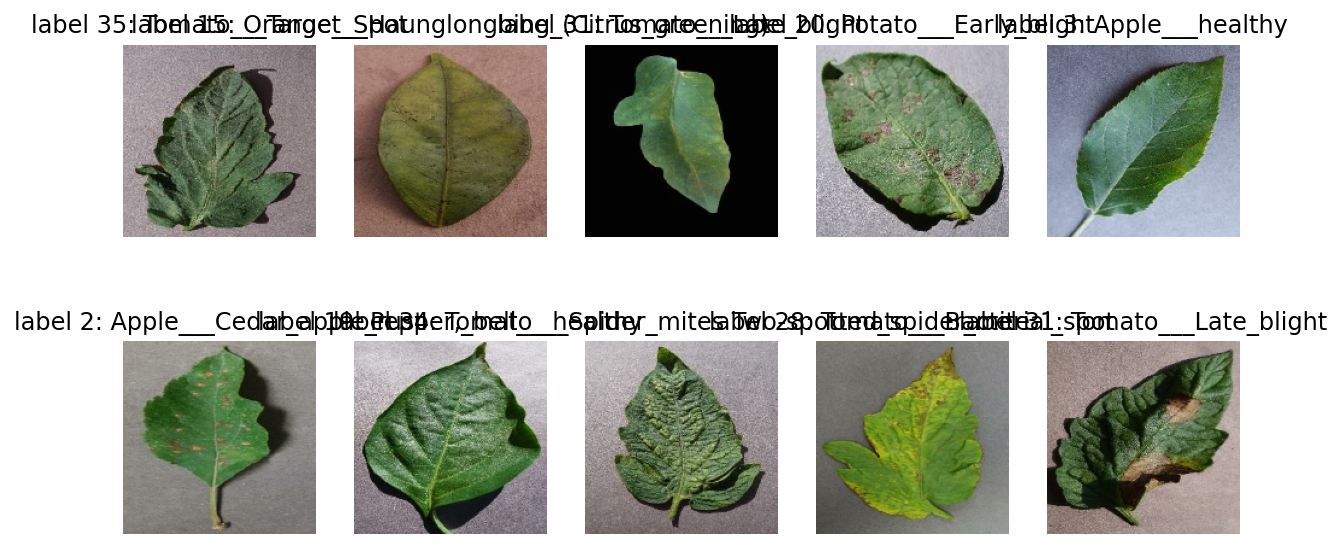

In [9]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

# 시도1) 분류 모델 구조 직접 설계

In [10]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

num_classes = metadata.features['label'].num_classes
print(f"Number of classes: {num_classes}")

model_attempt1 = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=num_classes, activation='softmax')
])

Number of classes: 38


# 직접 설계한 분류 모델 학습

In [12]:
learning_rate = 0.0001
model_attempt1.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
EPOCHS = 20

history_attempt1 = model_attempt1.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])

model_attempt1.save('model_attempt1.h5')

Epoch 1/20
1358/1358 [==============================] - 69s 33ms/step - loss: 1.0951 - accuracy: 0.6892 - val_loss: 0.6827 - val_accuracy: 0.7947
Epoch 2/20
1358/1358 [==============================] - 45s 33ms/step - loss: 0.4635 - accuracy: 0.8594 - val_loss: 0.5488 - val_accuracy: 0.8359
Epoch 3/20
1358/1358 [==============================] - 45s 33ms/step - loss: 0.2947 - accuracy: 0.9097 - val_loss: 0.3531 - val_accuracy: 0.8952
Epoch 4/20
1358/1358 [==============================] - 45s 33ms/step - loss: 0.2015 - accuracy: 0.9386 - val_loss: 0.3067 - val_accuracy: 0.9078
Epoch 5/20
1358/1358 [==============================] - 46s 33ms/step - loss: 0.1384 - accuracy: 0.9581 - val_loss: 0.2915 - val_accuracy: 0.9140
Epoch 6/20
1358/1358 [==============================] - 45s 33ms/step - loss: 0.0949 - accuracy: 0.9716 - val_loss: 0.2861 - val_accuracy: 0.9243
Epoch 7/20
1358/1358 [==============================] - 45s 33ms/step - loss: 0.0657 - accuracy: 0.9809 - val_loss: 0.2521 -

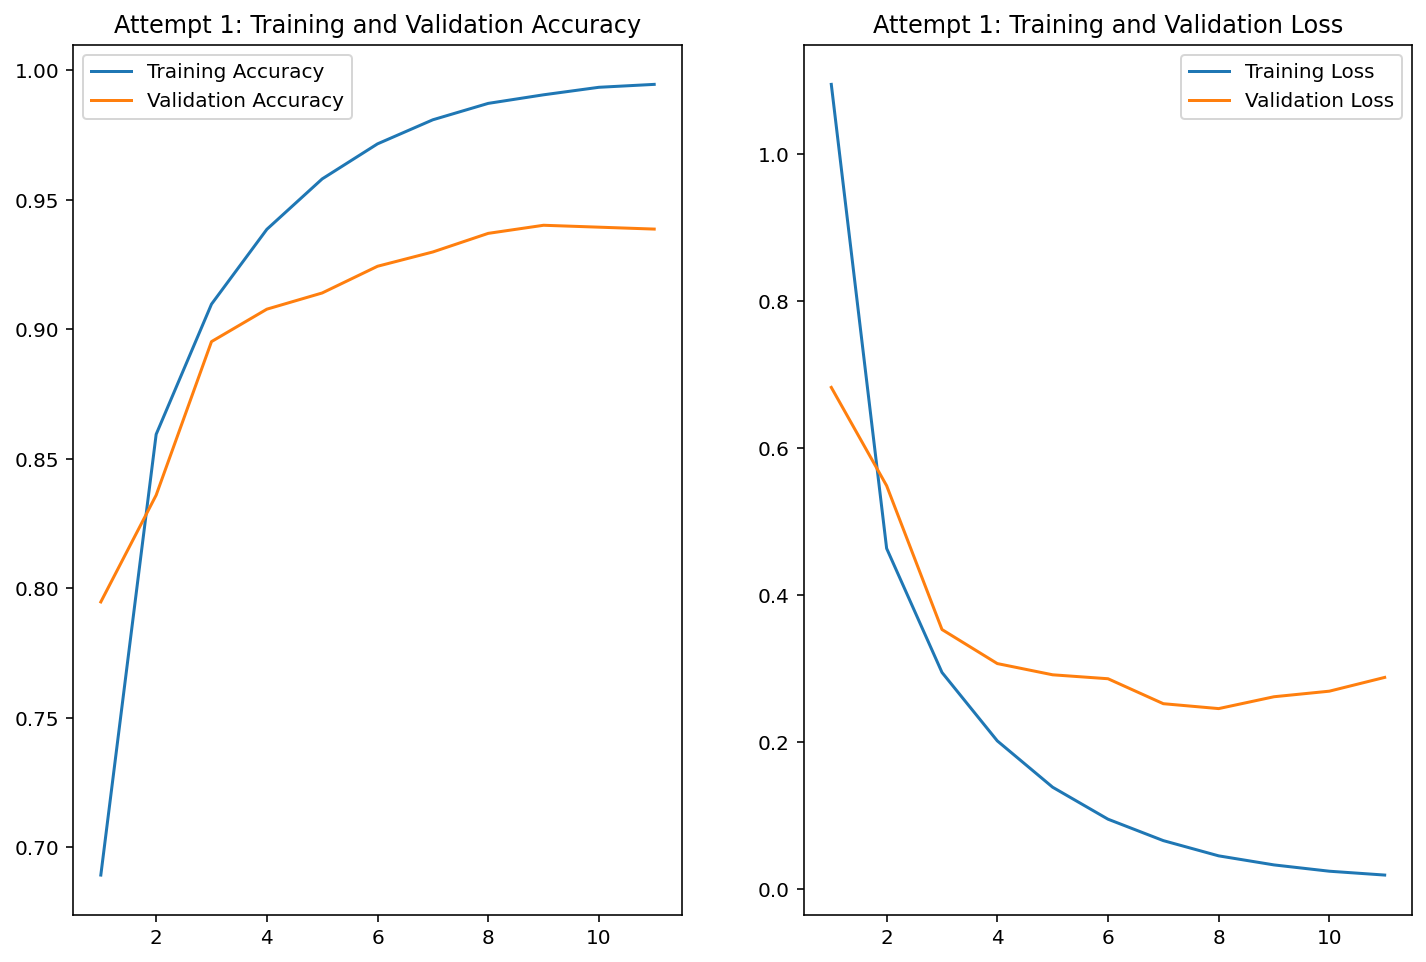

In [14]:
# 학습 곡선 시각화
acc_attempt1 = history_attempt1.history['accuracy']
val_acc_attempt1 = history_attempt1.history['val_accuracy']
loss_attempt1 = history_attempt1.history['loss']
val_loss_attempt1 = history_attempt1.history['val_loss']
epochs_attempt1 = range(1, len(acc_attempt1) + 1)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_attempt1, acc_attempt1, label='Training Accuracy')
plt.plot(epochs_attempt1, val_acc_attempt1, label='Validation Accuracy')
plt.legend()
plt.title('Attempt 1: Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_attempt1, loss_attempt1, label='Training Loss')
plt.plot(epochs_attempt1, val_loss_attempt1, label='Validation Loss')
plt.legend()
plt.title('Attempt 1: Training and Validation Loss')
plt.savefig('attempt1_learning_curve.png')
plt.show()

In [15]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model_attempt1.predict(image_batch)
    break

predictions

array([[9.32073672e-05, 1.19607626e-02, 5.93254198e-22, ...,
        6.11262976e-07, 1.54142083e-06, 2.50174339e-12],
       [3.26777837e-07, 5.85565505e-13, 4.10279704e-08, ...,
        5.49808199e-08, 4.06157889e-15, 7.34821405e-12],
       [8.74129219e-27, 6.01225918e-37, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.57941914e-24],
       ...,
       [1.77938254e-11, 1.29205127e-21, 1.37120343e-10, ...,
        9.22078844e-20, 1.79825697e-26, 1.70361906e-01],
       [1.13565416e-29, 0.00000000e+00, 3.46754207e-30, ...,
        0.00000000e+00, 0.00000000e+00, 9.85008041e-14],
       [7.58463159e-07, 1.04456239e-13, 5.97815781e-28, ...,
        1.65174169e-14, 1.20831105e-14, 3.48882733e-19]], dtype=float32)

In [16]:
predictions = np.argmax(predictions, axis=1)
predictions

array([ 3, 22,  9, 37, 36, 15, 16, 19, 16, 20, 15, 29, 25, 33,  8, 15, 28,
       34, 30, 35, 15, 29, 34,  3, 25, 15, 11, 24, 37, 28,  9,  3])

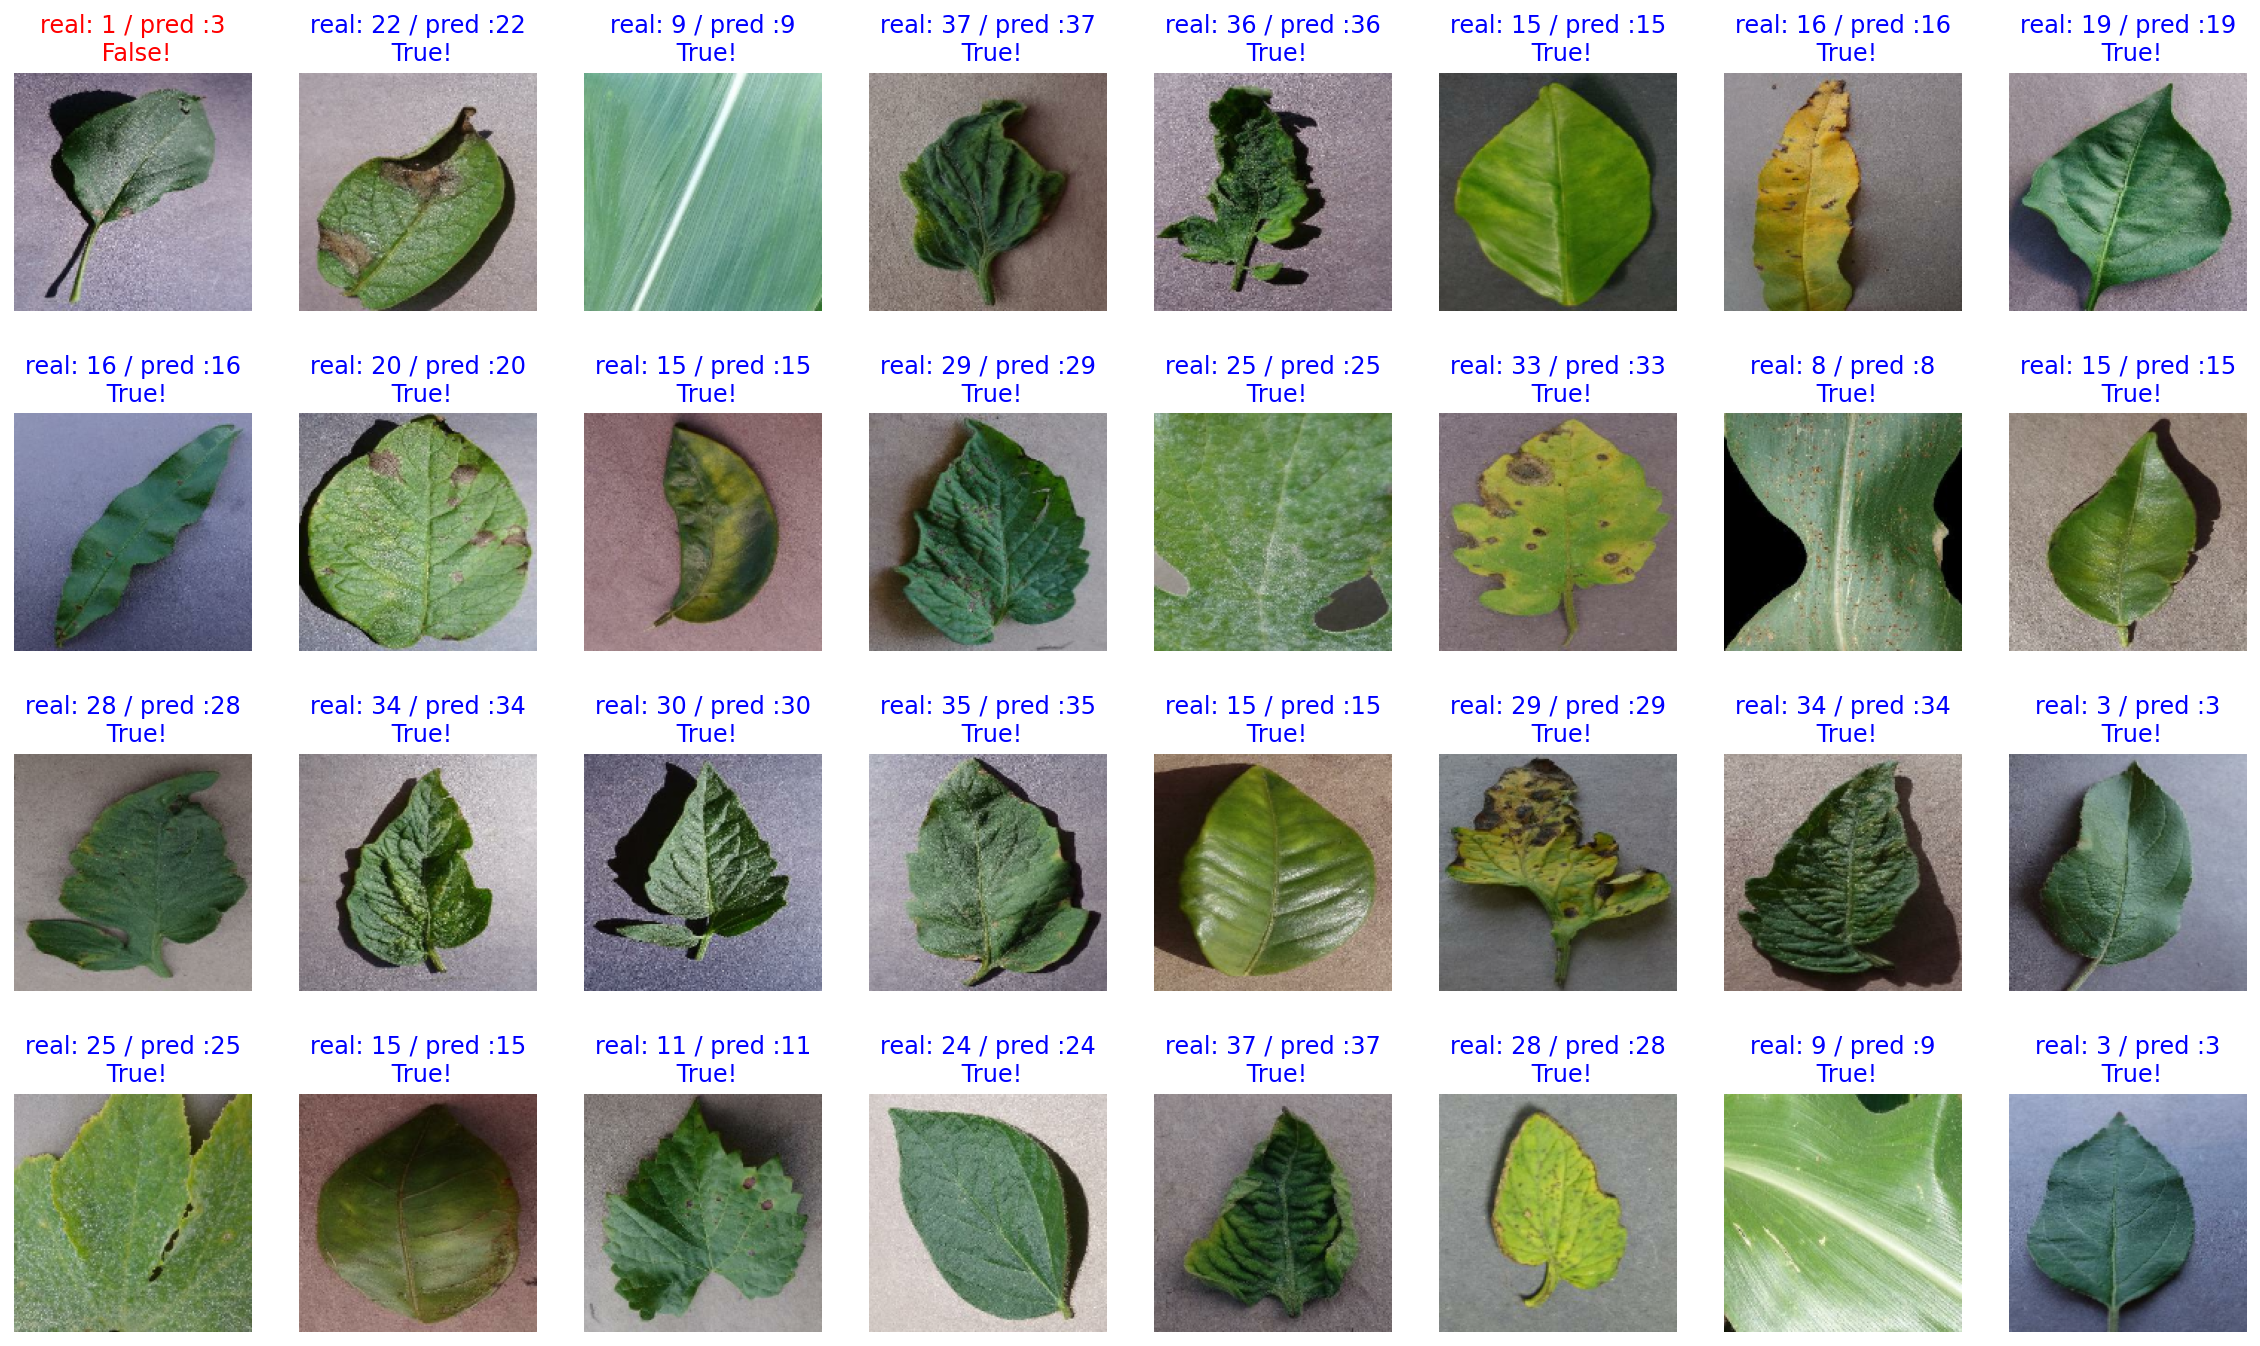

In [17]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [18]:
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
    if label == prediction:
        count = count + 1

print(count / 32 * 100)   

96.875


# 시도2) 전이학습 (VGG16)

In [19]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [20]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 512])

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [22]:
dense_layer = Dense(units=512, activation='relu')
prediction_layer = Dense(units=num_classes, activation='softmax')

prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

(32, 38)


In [23]:
base_model.trainable = False

model_attempt2 = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

In [24]:
base_learning_rate = 0.0001
model_attempt2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy, # label_mode에 따라 변경
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_attempt2 = model_attempt2.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])

Epoch 1/20
1358/1358 [==============================] - 124s 88ms/step - loss: 1.9136 - accuracy: 0.5388 - val_loss: 1.1559 - val_accuracy: 0.7233
Epoch 2/20
1358/1358 [==============================] - 114s 83ms/step - loss: 0.8637 - accuracy: 0.7975 - val_loss: 0.6924 - val_accuracy: 0.8295
Epoch 3/20
1358/1358 [==============================] - 114s 83ms/step - loss: 0.5784 - accuracy: 0.8536 - val_loss: 0.5229 - val_accuracy: 0.8625
Epoch 4/20
1358/1358 [==============================] - 113s 83ms/step - loss: 0.4550 - accuracy: 0.8774 - val_loss: 0.4325 - val_accuracy: 0.8796
Epoch 5/20
1358/1358 [==============================] - 116s 85ms/step - loss: 0.3857 - accuracy: 0.8910 - val_loss: 0.3834 - val_accuracy: 0.8903
Epoch 6/20
1358/1358 [==============================] - 113s 83ms/step - loss: 0.3401 - accuracy: 0.9030 - val_loss: 0.3470 - val_accuracy: 0.8965
Epoch 7/20
1358/1358 [==============================] - 113s 83ms/step - loss: 0.3081 - accuracy: 0.9109 - val_loss: 0

In [25]:
model_attempt2.save('model_attempt2.h5')

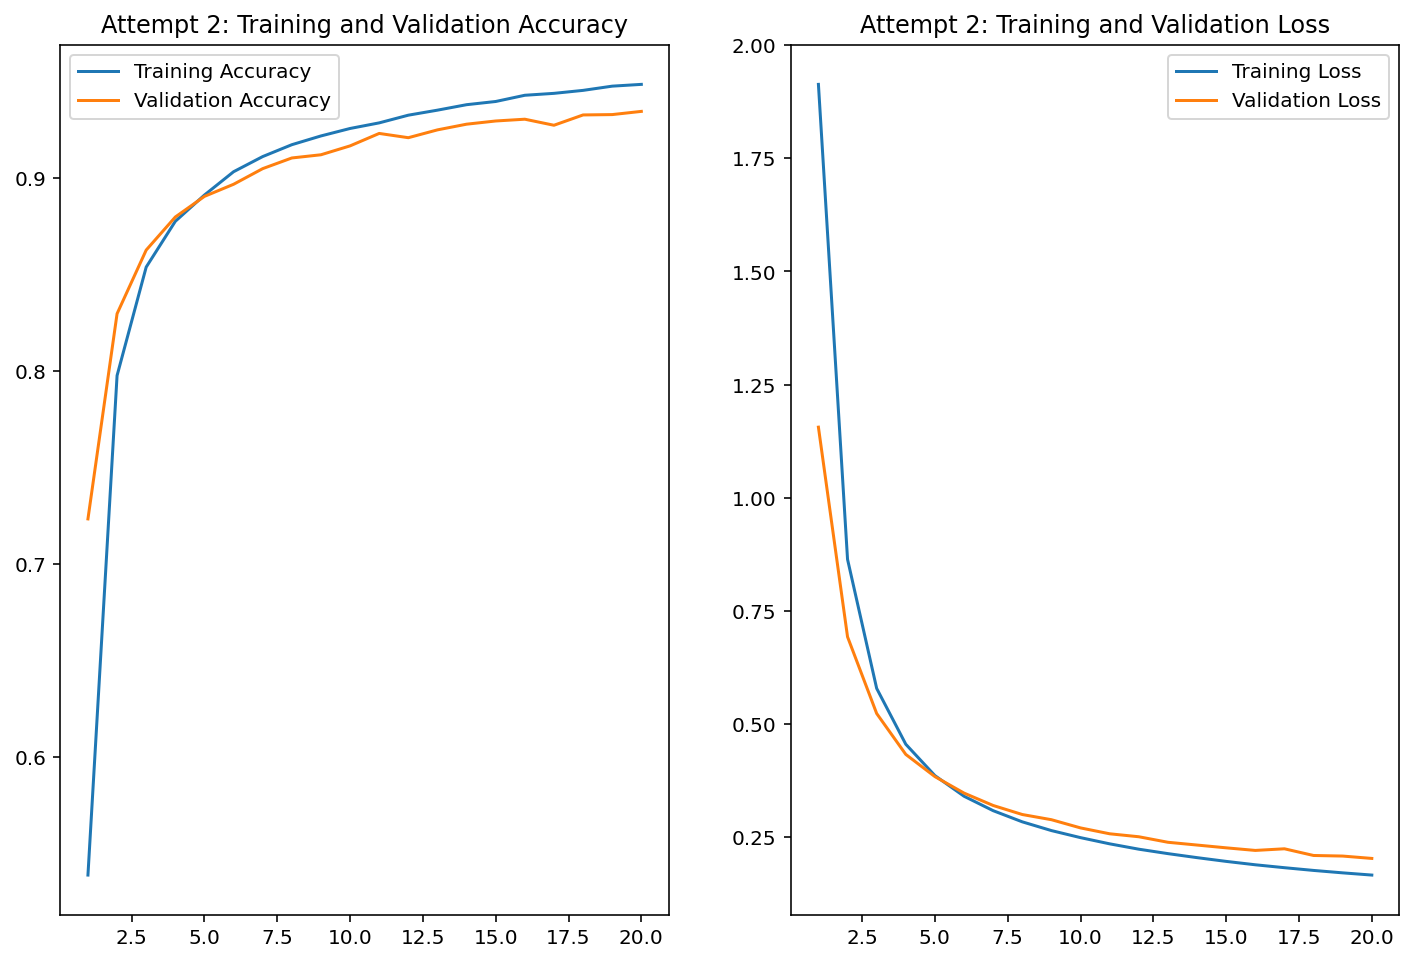

In [26]:
acc_attempt2 = history_attempt2.history['accuracy']
val_acc_attempt2 = history_attempt2.history['val_accuracy']
loss_attempt2 = history_attempt2.history['loss']
val_loss_attempt2 = history_attempt2.history['val_loss']
epochs_attempt2 = range(1, len(acc_attempt2) + 1)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_attempt2, acc_attempt2, label='Training Accuracy')
plt.plot(epochs_attempt2, val_acc_attempt2, label='Validation Accuracy')
plt.legend()
plt.title('Attempt 2: Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_attempt2, loss_attempt2, label='Training Loss')
plt.plot(epochs_attempt2, val_loss_attempt2, label='Validation Loss')
plt.legend()
plt.title('Attempt 2: Training and Validation Loss')
plt.savefig('attempt2_learning_curve.png')
plt.show()

In [34]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch.numpy() # NumPy 배열로 변환하여 다루기 쉽게 합니다
    labels = label_batch.numpy()
    break # 배치 하나만 필요합니다

# *전체* 모델로부터 예측을 수행합니다
predictions_probabilities = model_attempt2.predict(images)
# 각 이미지에 대해 가장 높은 확률의 인덱스(예측된 클래스)를 찾습니다
predicted_classes = np.argmax(predictions_probabilities, axis=1)

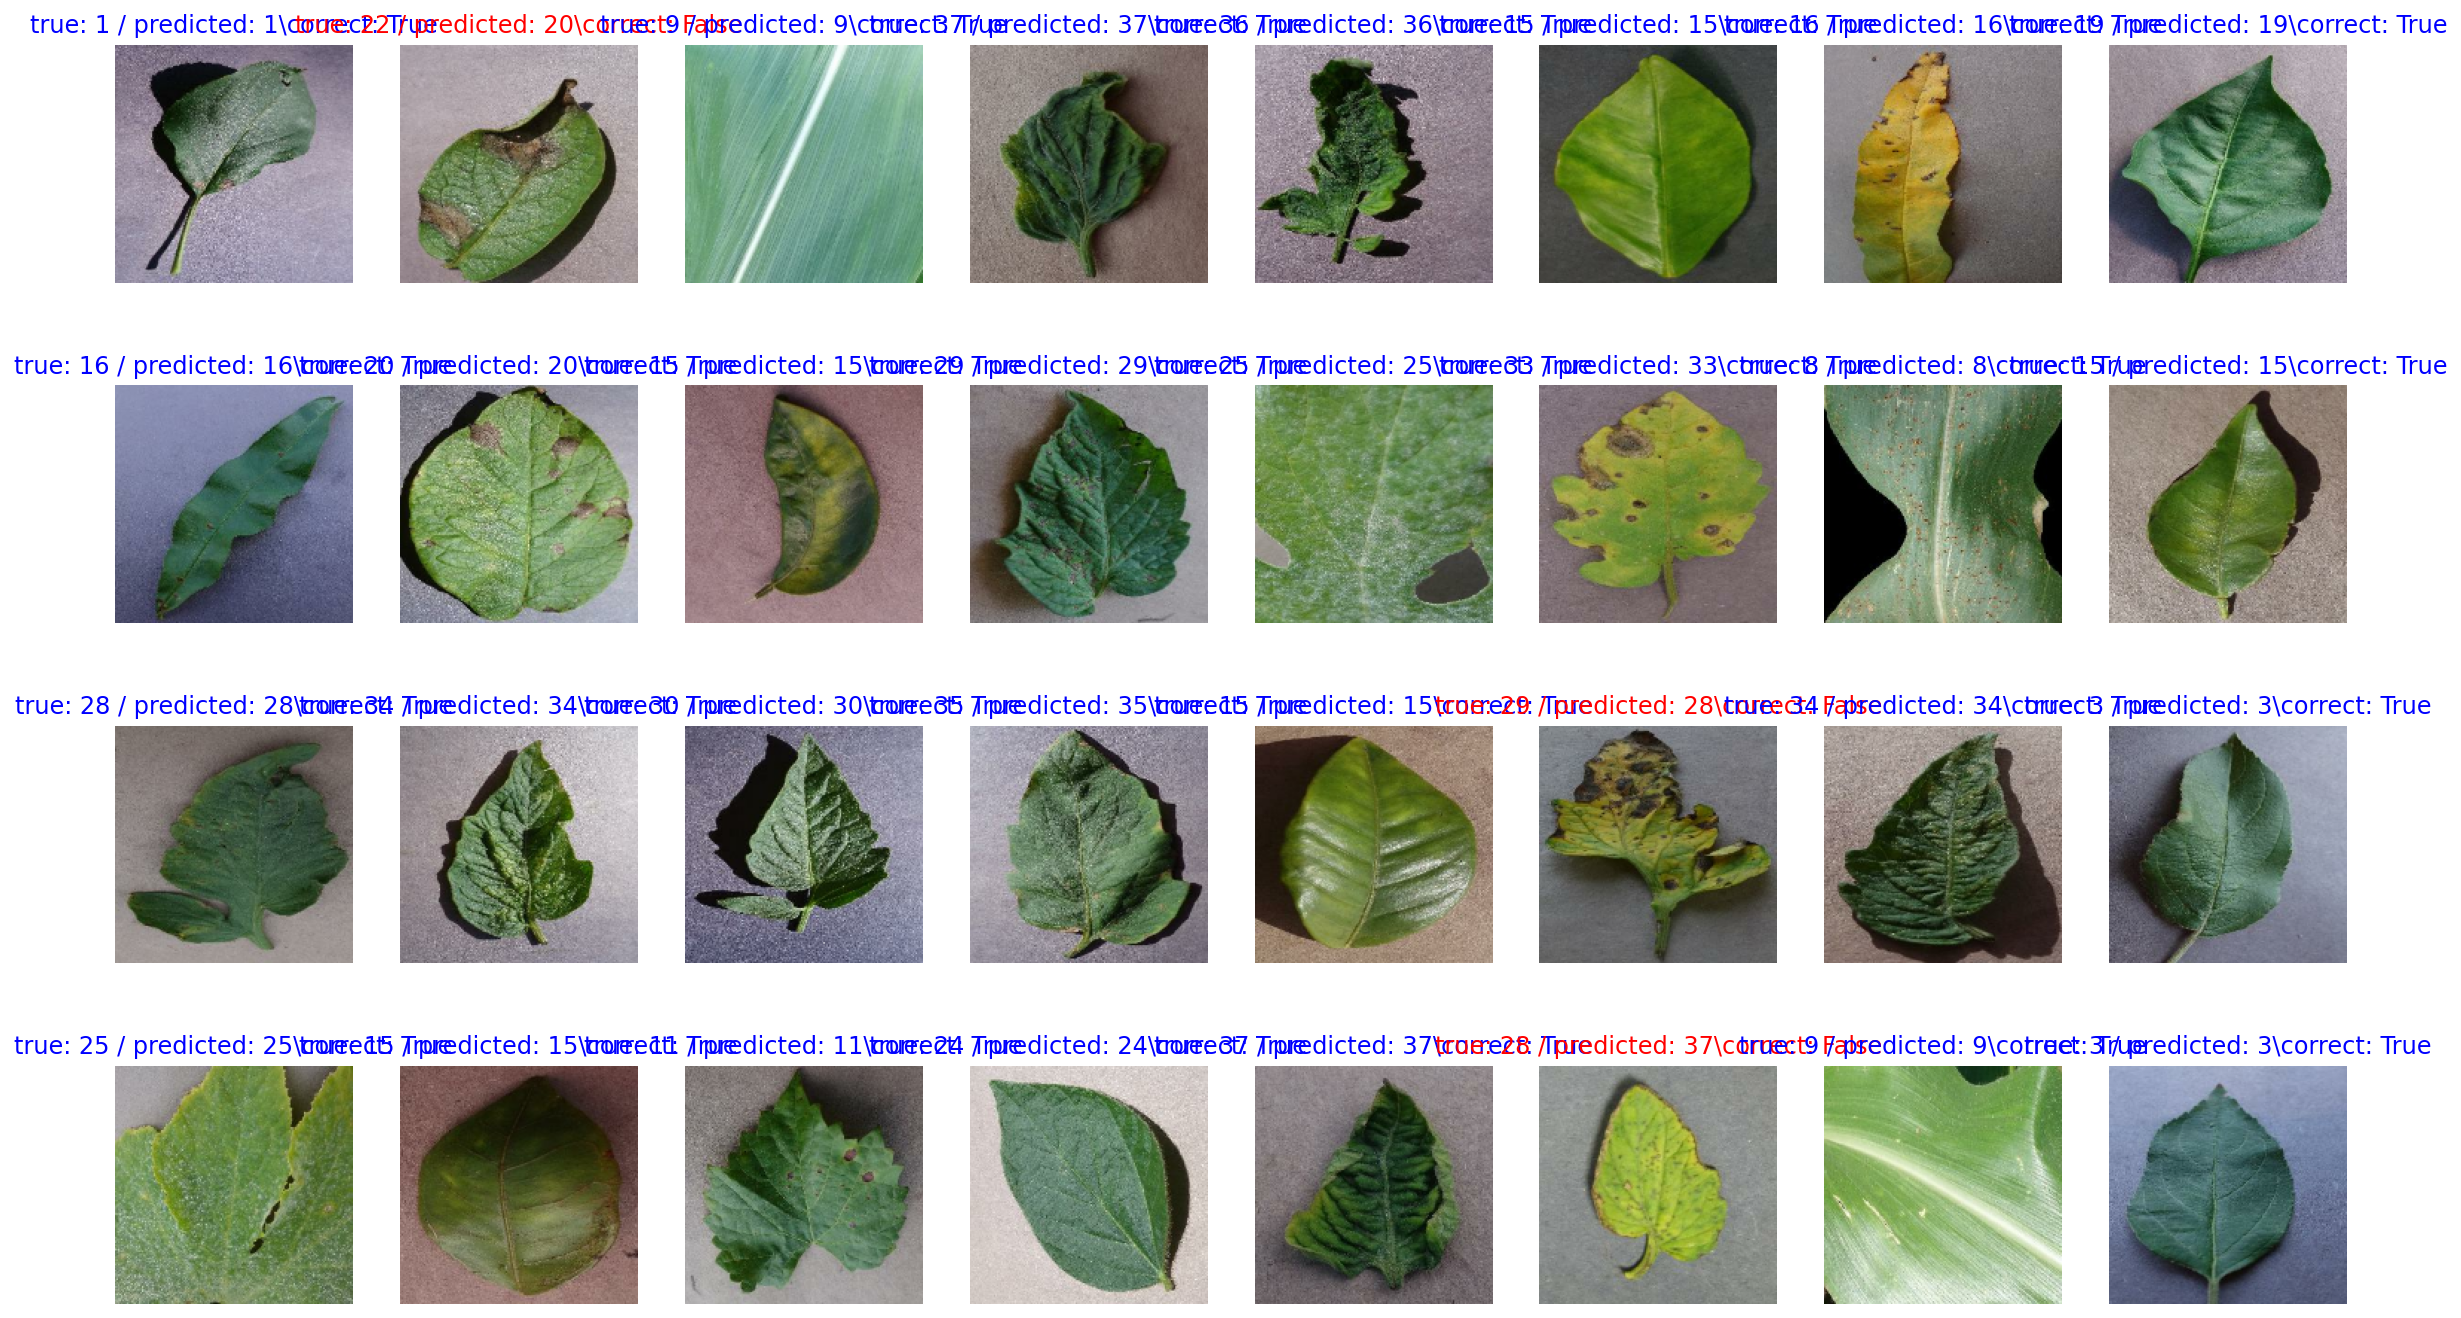

In [36]:
plt.figure(figsize=(20, 12)) # 필요에 따라 figsize 조정

# 그리드 크기 결정 (예: 배치 크기 32일 때 4행 8열)
num_images = images.shape[0]
rows = 4
cols = (num_images + rows - 1) // rows # 필요한 열 수를 계산합니다

for idx in range(num_images):
    plt.subplot(rows, cols, idx + 1)

    # 필요한 경우 이미지 정규화 해제 (정규화가 (x/127.5) - 1 이었다고 가정)
    # 만약 다르게 정규화했다면 이 단계를 조정하세요
    image = (images[idx] * 127.5 + 127.5).astype(np.uint8) # 일반적인 정규화 복원 방법
    # 또는 만약 1./255로만 스케일링했다면:
    # image = (images[idx] * 255).astype(np.uint8)

    plt.imshow(image)

    true_label = labels[idx]           # 실제 레이블
    predicted_label = predicted_classes[idx] # 예측된 레이블
    correct = (true_label == predicted_label) # 정답 여부 확인

    title = f'true: {true_label} / predicted: {predicted_label}\correct: {correct}'
    color = 'blue' if correct else 'red' # 정답 여부에 따라 제목 색상 설정

    plt.title(title, fontdict={'color': color})
    plt.axis('off') # 축 숨기기


In [37]:
count = 0  # 정답을 맞춘 개수
batch_size = len(labels) # 실제 배치 크기 가져오기

# 실제 레이블과 예측된 클래스를 직접 비교
for true_label, predicted_label in zip(labels, predicted_classes):
    if true_label == predicted_label:
        count += 1 # count = count + 1 과 동일

# 정확도 계산 및 출력 (소수점 2자리까지)
accuracy = (count / batch_size) * 100
print(f"이 배치에서의 정확도: {accuracy:.2f}%")

이 배치에서의 정확도: 90.62%


# 직접 설계 모델 VS VGG16 비교

## 두 모델 모두 약 93-94% 수준의 괜찮은 검증 정확도

-  설계 모델 (시도 1): 약간 더 높은 최고 검증 정확도를 빠르게 달성했지만, 심각한 **과대적합 문제점**을 드러냈습니다.
- 학습 곡선과 로그를 보면, 훈련 정확도는 99% 이상으로 치솟는 반면 검증 정확도는 약 94%에서 정체되고 검증 손실은 Epoch 8 이후 증가하는 뚜렷한 과대적합 경향을 보입니다. 이 때문에 훈련이 조기 종료되었습니다.

- G16 전이학습 모델 (시도 2): 최고 정확도는 약간 낮았지만, 훨씬 낮은 검증 손실 값을 기록하며 과대적합을 효과적으로 억제했습니다. 이는 더 안정적이고 일반화 성능이 뛰어난 모델일 가능성이 높음을 의미합니다. Epoch 당 학습 시간은 더 길었습니다.

### 따라서 VGG16 전이학습 모델(시도 2)이 이 문제에 대해 더 견고하고 신뢰할 수 있는 모델로 판단됩니다. 약간의 정확도 차이보다는 낮은 검증 손실과 과대적합 억제 능력이 실제 활용 시 더 중요할 수 있습니다.

# VGG16로 학습한 h5 파일 -> tflite로 변환

In [40]:
model = tf.keras.models.load_model('model_attempt2.h5')

# TFLite 변환기 생성
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

# 변환 수행
tflite_model = converter.convert()

# .tflite 파일로 저장
with open('plant_model.tflite', 'wb') as f:
  f.write(tflite_model)

print("모델 변환 완료: plant_model.tflite")

INFO:tensorflow:Assets written to: /tmp/tmpiunfyax7/assets


INFO:tensorflow:Assets written to: /tmp/tmpiunfyax7/assets


모델 변환 완료: plant_model.tflite


## labels.txt에 필요한 레이블 확인

In [41]:
metadata.features['label'].names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry___healthy',
 'Cherry___Powdery_mildew',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___healthy',
 'Corn___Northern_Leaf_Blight',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___healthy',
 'Strawberry___Leaf_scorch',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomat